# Forecast

In [1]:
from datetime import datetime, timedelta
from eralchemy import render_er
from IPython.display import display
from PIL import Image
from sqlalchemy import create_engine

import pandas as pd
import psycopg2
import sqlalchemy as sqla
import sqlite3

## Table Creation

In [2]:
# connection
conn = sqlite3.connect('/tmp/forecast.db')

c = conn.cursor()

c.execute('DROP TABLE IF EXISTS CID10;')
c.execute('DROP TABLE IF EXISTS Municipio;')
c.execute('DROP TABLE IF EXISTS forecast_model;')
c.execute('DROP TABLE IF EXISTS forecast_city;')
c.execute('DROP TABLE IF EXISTS forecast;')

# Create CID10 table
c.execute('''
CREATE TABLE IF NOT EXISTS CID10 (
    codigo character varying(5) NOT NULL PRIMARY KEY,
    nome character varying(512) NOT NULL
)''')

# Create Municipio table
c.execute('''
CREATE TABLE IF NOT EXISTS Municipio (
  geocodigo integer NOT NULL PRIMARY KEY,
  nome character varying(128) NOT NULL,
  geojson text NOT NULL,
  populacao bigint NOT NULL,
  uf character varying(20) NOT NULL
)''')

# Create forecast_model table
c.execute('''
CREATE TABLE IF NOT EXISTS forecast_model (
    id INT NOT NULL PRIMARY KEY,
    name VARCHAR(128) NOT NULL,
    total_weeks SMALLINT NOT NULL,
    commit_id CHAR(7) NOT NULL,
    active BOOL NOT NULL
)''')

# Create forecast table
c.execute('''
CREATE TABLE IF NOT EXISTS forecast (
    epiweek INT NOT NULL,
    geoid INT NOT NULL,
    cid10 character varying(5) NOT NULL,
    forecast_model_id INT,
    published_date date NOT NULL,
    init_date_epiweek date NOT NULL,
    cases INT NOT NULL,
    PRIMARY KEY (epiweek, geoid, cid10, forecast_model_id, published_date),
    FOREIGN KEY(forecast_model_id) REFERENCES forecast_model(id),
    FOREIGN KEY(geoid) REFERENCES Municipio(geocodigo)
    --FOREIGN KEY(cid10) REFERENCES CID10(codigo)
)''')

# Create forecast_city table
c.execute('''
CREATE TABLE IF NOT EXISTS forecast_city (
    geoid INT NOT NULL,
    forecast_model_id INT,
    active BOOL NOT NULL,
    PRIMARY KEY (geoid, forecast_model_id),
    FOREIGN KEY(forecast_model_id) REFERENCES forecast_model(id),
    FOREIGN KEY(geoid) REFERENCES Municipio(geocodigo)
)''')


# close connection
conn.close()

/home/xmn/miniconda3/envs/alertadengue/lib/python3.6/site-packages/sqlalchemy/dialects/sqlite/base.py:1425: SAWarning: WARNING: SQL-parsed foreign key constraint '('cid10', 'CID10', 'codigo')' could not be located in PRAGMA foreign_keys for table forecast
  table_name


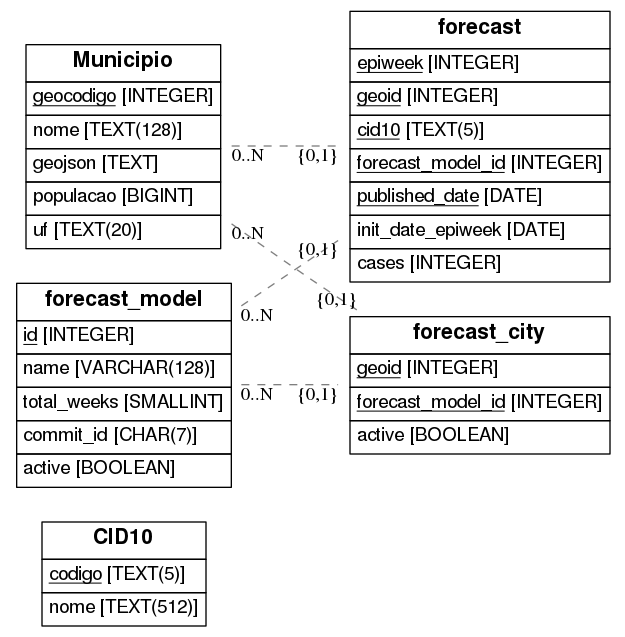

In [3]:
render_er('sqlite:////tmp/forecast.db', '/tmp/img.png')
Image.open('/tmp/img.png')

## Generate samples

In [4]:
def generate_sample(output):
    sql = '''
    INSERT INTO "Municipio".forecast 
    VALUES (%s,%s,'%s','%s',%s,\'%s\',\'%s\');
    '''.replace('\n', '').strip()
    
    CID10 = {
        'dengue': 'A90',
        'zika': 'A928',
        'chikungunya': 'A920'
    }
    
    cities = {
        'curitiba': 4106902,
        'rio': 3304557
    }
    
    for city_name, geoid in cities.items():
        for cid_name, cid_id in CID10.items():
            for w in range(1, 54):
                d = datetime.strptime('2017-01-01', '%Y-%m-%d') + timedelta(days=7*w)

                init_date = d.strftime('%Y-%m-%d')
                epiweek = '2017%s' % str(w).rjust(2, '0')
                cases = (w ** 2) * 10
                model_id = str(w)[0] * 128
                commit_id = str(w)[0] * 7

                text = sql % (
                    epiweek, geoid, cid_id,
                    init_date, cases, model_id, commit_id
                )

                print(text, file=output)

In [5]:
with open('/tmp/insert.sql', 'w') as f:
    generate_sample(f)

In [6]:
def get_passwd_from_ini(filepath: str):
    with open(filepath) as f:
        text = f.read()
        i = text.index('PSQL_PASSWORD')
        f = text[i:].index('\n')
        passwd = text[i:i+f].split('=')
        return passwd[1].strip()

In [7]:
db = 'dengue'
user = 'dengueadmin'
host = 'localhost'
passwd = get_passwd_from_ini('../AlertaDengue/AlertaDengue/settings.ini')

In [8]:
engine = create_engine("postgresql://{}:{}@{}/{}".format(
    user, passwd, host, db
))

In [9]:
sql = """
SELECT 
    (CASE 
     WHEN tb_cases."data_iniSE" IS NOT NULL 
       THEN tb_cases."data_iniSE" 
     ELSE forecast.init_date_epiweek
     END
    ) AS "data_iniSE",
    tb_cases.casos_est_min,
    tb_cases.casos_est,
    tb_cases.casos_est_max,
    tb_cases.casos,
    tb_cases.nivel,
    (CASE 
     WHEN tb_cases."SE" IS NOT NULL THEN tb_cases."SE" 
     ELSE forecast.epiweek
     END
    ) AS "SE",
    tb_cases.p_rt1,
    forecast.cases AS forecast_cases 
FROM
    (SELECT 
       data AS "data_iniSE",
       SUM(casos_estmin) AS casos_est_min,
       SUM(casos_est) as casos_est,
       SUM(casos_estmax) AS casos_est_max,
       SUM(casos) AS casos,
       MAX(nivel) AS nivel,
       se AS "SE",
       SUM(prt1) AS p_rt1
     FROM "Municipio".alerta_mrj
     GROUP BY "data_iniSE", "SE"
    ) AS tb_cases FULL OUTER JOIN "Municipio".forecast
      ON (tb_cases."SE" = forecast.epiweek)
ORDER BY "data_iniSE" ASC
"""

df = pd.read_sql(sql, con=engine)

In [10]:
df['casos_est'].isnull().any()

True